# Analiza danych do szkolenia modelu detekcji obiektów

## Wprowadzenie

W tym notatniku Jupyter przeprowadzimy kompleksową analizę zbioru danych w celu określenia jego przydatności do szkolenia eksperymentalnego modelu detekcji obiektów. Nasza analiza będzie podzielona na osobne karty, z których każda będzie zajmować się konkretnymi aspektami zbioru danych. Kluczowe punkty, które będziemy badać, obejmują:

1. **Zrównoważenie Klas:** Na tej karcie zbadamy rozkład klas w zbiorze danych, aby zapewnić zrównoważoną reprezentację.

2. **Rozmiary Obrazów:** W następnej karcie przeanalizujemy rozmiary obrazów w zbiorze danych.

3. **Liczba Adnotacji:** Przechodząc dalej, zbadamy liczbę adnotacji obecnych na każdym obrazie, co jest kluczowe dla szkolenia modelu.

4. **Umieszczenie i Rozmiar Adnotacji:** Na ostatniej karcie ocenimy umieszczenie i rozmiar adnotacji na obrazach, co pozwoli nam lepiej zrozumieć jakość zbioru danych.

Analizowany zbiór danych został pobrany ze strony internetowej Roboflow i jest oceniany pod kątem jego przydatności do opracowania modelu zdolnego do wykrywania obiektów. Nasza analiza odegra kluczową rolę w decyzji, czy ten zbiór danych spełnia niezbędne kryteria do skutecznego szkolenia modelu.

Nasze strukturalne podejście zapewnia, że dokładnie ocenimy każdy aspekt zbioru danych. Rozpoczniemy od przetwarzania danych, aby przygotować zbiór do analizy, a następnie przedstawimy tabele i wykresy prezentujące nasze wyniki.

Poprzez przeprowadzenie tej analizy mamy nadzieję dostarczyć wartościowych wniosków na temat jakości zbioru danych i jego przydatności do szkolenia pożądanego modelu detekcji obiektów.


# Pobieranie datasetu

In [4]:
%matplotlib inline

In [ ]:
from dotenv import dotenv_values
config = dotenv_values('.env')
from roboflow import Roboflow
rf = Roboflow(api_key=config['API_KEY'])
project = rf.workspace("personal-protective-equipment").project("ppes-kaxsi")
dataset = project.version(4).download("coco")

# Wczytywanie danych do słowników

W tym segmencie wczytamy istotne informacje z katalogów "train" i "valid" do słowników. Informacje zawarte w tych katalogach są kluczowe dla naszej analizy i zrozumienia zbioru danych.

Naszym celem jest zebranie i uporządkowanie danych w strukturalny format, który ułatwi kolejną analizę. Poprzez wczytanie danych do słowników, będziemy mogli łatwo uzyskać dostęp do kluczowych atrybutów, takich jak etykiety klas, rozmiary obrazów i szczegóły adnotacji.

Ten początkowy krok jest fundamentalny dla przygotowania zbioru danych do naszej kompleksowej analizy. Po uporządkowaniu danych w słownikach przystąpimy do badania różnych aspektów zbioru danych na osobnych kartach, w tym zrównoważenia klas, rozmiarów obrazów, liczby adnotacji i umiejscowienia adnotacji.

Rozpocznijmy od wczytania niezbędnych danych do naszych słowników, aby rozpocząć naszą analizę.

In [4]:
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import numpy as np
import pandas as pd
import json


In [5]:
train_path = os.path.join('PPEs-4', 'train')
valid_path = os.path.join('PPEs-4', 'valid')

In [6]:
train_info = {}

for i in os.listdir('PPEs-4/train'):
  if i.endswith('.json'):
    with open(os.path.join(train_path, i), encoding='UTF-8') as file_in:
      train_info = json.load(file_in)
    break

In [7]:
valid_info = {}

for i in os.listdir('PPEs-4/train'):
  if i.endswith('.json'):
    with open(os.path.join(valid_path, i), encoding='UTF-8') as file_in:
      valid_info = json.load(file_in)
    break

In [8]:
mapped_categories = {category['id'] : category['name'].replace('_', ' ').replace('-', ' ').capitalize() for category in train_info['categories']}

## Każdy z kolejnych segmentów jest podzielony na karty:
1. **Przetwarzanie Danych:** *Karta Process*
2. **Wizualizacja:** *Karta Show*


# Analiza Zrównoważenia Klas

## Wprowadzenie

W tej sekcji zagłębimy się w kluczowy aspekt zrównoważenia klas w zbiorze danych. Zrównoważenie klas odnosi się do rozkładu obiektów lub kategorii w różnych klasach lub etykietach w naszym zbiorze danych. Jest to istotny czynnik do rozważenia podczas przygotowywania zbioru danych do szkolenia modelu detekcji obiektów.

Zrównoważenie klas może znacząco wpłynąć na wydajność i skuteczność modelu. Zestaw danych niezrównoważony, gdzie niektóre klasy są nadreprezentowane, podczas gdy inne są niedoreprezentowane, może prowadzić do uprzedzonych prognoz modelu i słabej generalizacji.

Zrównoważony zbiór danych zapewnia, że model ma równą szansę na naukę z wszystkich klas, co prowadzi do lepszej ogólnej wydajności. Z kolei niezrównoważone zbiory danych mogą wymagać zastosowania technik takich jak oversampling, undersampling lub uwzględnienie wagi klas podczas szkolenia modelu w celu złagodzenia efektów niezrównoważenia klas.

Rozpocznijmy od przetwarzania danych, aby ocenić zrównoważenie klas w naszym zbiorze danych.


## Process

In [9]:
def categories_values_summary(df):
  df_copy = df.copy()
  df_copy = df_copy.value_counts().reset_index(name='counts').set_index('category_id')
  df_copy['percentage'] = ((df_copy['counts']/df_copy['counts'].sum())*100).round(2)
  df_copy['percentage'] = df_copy['percentage'].astype(str) + ' %'
  return df_copy

In [10]:
def categories_values_pie(df):
  cat_summ = categories_values_summary(df)
  fig = plt.figure()
  plt.barh(cat_summ['category_name'], cat_summ['counts'], label=['TEST'] * len(cat_summ))
  plt.grid(axis='x', linestyle='--')
  plt.xticks(range(0, max(cat_summ['counts'])+1, 500))
  for i in range(0, max(cat_summ['counts'])+1, 1000):
    plt.axvline(i, color='lightgray')
  plt.gca().invert_yaxis()
  plt.xlabel('Counts')
  plt.ylabel('Category Name')
  plt.title('Class Balance')
  plt.close()
  return fig

In [11]:
train_df = pd.DataFrame(train_info['annotations'], columns=['id','category_id'])
train_df.set_index('id', inplace=True)
valid_df = pd.DataFrame(valid_info['annotations'], columns=['id','category_id'])
valid_df.set_index('id', inplace=True)
train_df['category_name'] = train_df['category_id'].map(mapped_categories)
valid_df['category_name'] = valid_df['category_id'].map(mapped_categories)

In [12]:
train_categories_values_summary = categories_values_summary(train_df)
train_categories_values_bar = categories_values_pie(train_df)
valid_categories_values_summary = categories_values_summary(train_df)
valid_categories_values_bar = categories_values_pie(train_df)
del train_df, valid_df

## Show

### Podsumowanie Kategorii

Wynikiem przetwarzania danych jest tabela reprezentująca podsumowanie kategorii obiektów, dostarczająca informacji na temat rozkładu klas.


In [13]:
#TRAIN DATA
train_categories_values_summary

,category_name,counts,percentage
category_id,,,
6,No glove,4885,24.81 %
1,Glove,3705,18.82 %
2,Goggles,3361,17.07 %
7,No goggles,3293,16.73 %
3,Helmet,1240,6.3 %
8,No helmet,1067,5.42 %
11,Shoes,570,2.9 %
9,No mask,524,2.66 %
10,No shoes,463,2.35 %


In [14]:
#VALID DATA
valid_categories_values_summary

,category_name,counts,percentage
category_id,,,
6,No glove,4885,24.81 %
1,Glove,3705,18.82 %
2,Goggles,3361,17.07 %
7,No goggles,3293,16.73 %
3,Helmet,1240,6.3 %
8,No helmet,1067,5.42 %
11,Shoes,570,2.9 %
9,No mask,524,2.66 %
10,No shoes,463,2.35 %


### Wykres Słupkowy Kategorii

Wynikiem przetwarzania danych jest wykres słupkowy, który wizualnie przedstawia rozkład klas.


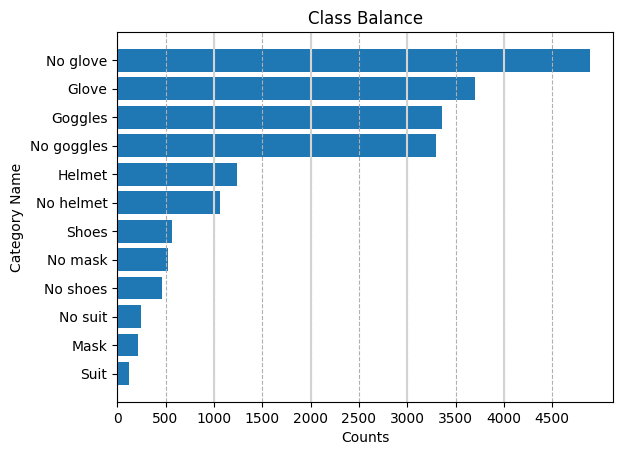

In [15]:
#TRAIN DATA
train_categories_values_bar

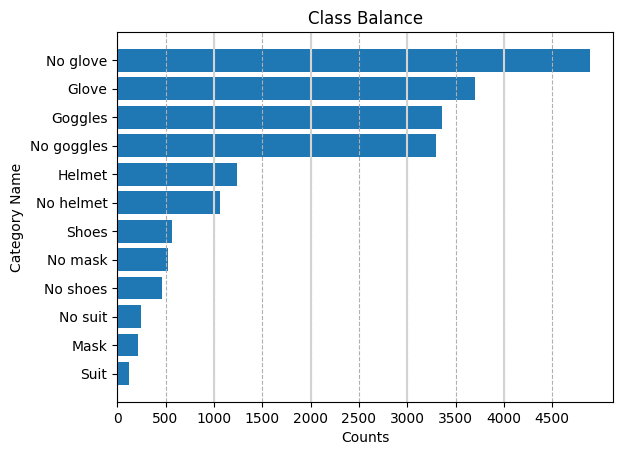

In [16]:
#VALID DATA
valid_categories_values_bar

## Podsumowanie

W naszej analizie zrównoważenia klas w zbiorze danych zdobyliśmy cenne informacje na temat rozkładu kategorii obiektów lub etykiet klas. Zrozumienie zrównoważenia klas jest niezbędne do przygotowania zbioru danych, który zostanie użyty do szkolenia modelu detekcji obiektów. Możemy wyciągnąć następujące kluczowe obserwacje i wnioski:

1. **Zrównoważone i Niezrównoważone Klasy:** Podczas gdy niektóre klasy wykazują względnie zrównoważony rozkład, inne wydają się być niezrównoważone. Warto zauważyć, że kategorie "No Gloves" i "Gloves" dominują w zbiorze danych, razem stanowiąc ponad 43% danych. To niezrównoważenie klas może potencjalnie wpłynąć na wydajność modelu, ze skłonnością do tych klas podczas szkolenia.

2. **Klasy Mniejszościowe:** Klasy takie jak "Mask," "Suit" i "Shoes" stanowią mniejszą część zbioru danych, reprezentując każda mniej niż 3% ogólnej liczby próbek. Zapewnienie odpowiedniego uwzględnienia tych klas mniejszościowych podczas szkolenia może wymagać technik augmentacji danych lub specjalistycznych strategii treningowych.

Podsumowując, zrozumienie zrównoważenia klas w zbiorze danych to kluczowy krok w przygotowaniach do szkolenia modelu detekcji obiektów. Rozpoznawanie niezrównoważeń i podejmowanie odpowiednich działań w celu ich rozwiązania przyczyni się do zdolności modelu do dokładnych prognoz we wszystkich klasach. Kolejne kroki mogą obejmować augmentację danych, specjalistyczne treningi i dostrojenie modelu w celu optymalizacji jego wydajności.


# Analiza Rozmiarów Obrazów

## Wprowadzenie

W tej sekcji zajmiemy się analizą rozmiarów obrazów w naszym zbiorze danych. Zrozumienie rozkładu wymiarów obrazów to istotny aspekt przygotowań zbioru danych do szkolenia modelu detekcji obiektów. Rozmiar obrazu wpływa na architekturę modelu, czas szkolenia oraz wymagane zasoby obliczeniowe.

Poprzez analizę rozmiarów obrazów dążymy do zapewnienia, że nasz zbiór danych jest odpowiednio przygotowany do szkolenia modelu detekcji obiektów. Obejmuje to rozważenie zmienności wymiarów obrazów, skalowanie lub przycinanie obrazów, jeśli to konieczne, oraz dostosowanie architektury modelu do cech zbioru danych.

Rozpocznijmy od przetwarzania danych w celu analizy rozkładu rozmiarów obrazów.


## Process

In [17]:
def images_values_summary(df):
  VALUES_SPLIT = 10

  df_copy = df.copy()
  values_count = df_copy.value_counts().reset_index(name='count')
  top_values = values_count.head(VALUES_SPLIT).copy()
  top_values['size'] = top_values['width'].astype(str) + ' x ' + top_values['height'].astype(str)
  top_values = top_values.drop(['height', 'width'], axis=1)
  top_values = top_values[['size', 'count']]
  other_values = values_count.iloc[VALUES_SPLIT:]['count'].sum()
  summary_values = pd.concat([top_values, pd.DataFrame({'count':[other_values], 'size':['Other']})]).reset_index(drop=True).set_index('size')
  return summary_values

In [18]:
def images_size_plot(df):
  df_copy = df.copy()
  df_copy = df_copy.groupby(['height', 'width']).agg('size').reset_index(name='count')

  cmap = sns.color_palette("Accent", as_cmap=True)
  min_dot_size = 30
  max_dot_size = 800
  min_count = df_copy['count'].min()
  max_count = df_copy['count'].max()

  df_copy['normalized_count'] = (df_copy['count'] - min_count) / (max_count - min_count)
  df_copy['dot_size'] = min_dot_size + (max_dot_size - min_dot_size) * df_copy['normalized_count']

  fig = plt.figure()
  plt.scatter(df_copy['width'],
              df_copy['height'],
              c=df_copy['count'],
              cmap=cmap,
              s=df_copy['dot_size'],
              alpha=0.4,
              edgecolor='black')

  cbar = plt.colorbar()
  cbar.set_label('Count')

  plt.xlabel('Width')
  plt.ylabel('Height')
  plt.title('Size of images')
  plt.close()

  return fig

In [19]:
train_df = pd.DataFrame(train_info['images'], columns=['id','height', 'width'])
train_df.set_index('id', inplace=True)
valid_df = pd.DataFrame(valid_info['images'], columns=['id','height', 'width'])
valid_df.set_index('id', inplace=True)

In [20]:
train_images_values_summary = images_values_summary(train_df)
train_images_size_plot = images_size_plot(train_df)
valid_images_values_summary = images_values_summary(valid_df)
valid_images_size_plot = images_size_plot(valid_df)
del valid_df, train_df

## Show

### Podsumowanie Rozmiarów Obrazów

Wynikiem przetwarzania danych jest tabela przedstawiająca podsumowanie rozmiarów obrazów ograniczone do 10 najczęstszych rozmiarów.


In [21]:
#TRAIN DATA
train_images_values_summary

,count
size,
1280 x 720,7813
2048 x 1536,1195
2688 x 1520,339
1920 x 1080,49
500 x 333,49
500 x 375,18
500 x 334,16
450 x 300,9
500 x 332,7


In [22]:
#VALID DATA
valid_images_values_summary

,count
size,
1280 x 720,1945
2048 x 1536,279
2688 x 1520,93
1920 x 1080,16
500 x 375,4
500 x 333,4
500 x 332,2
499 x 333,2
640 x 959,1


### Wykres Rozrzutu Rozmiarów Obrazów

Wynikiem przetwarzania danych jest wykres rozrzutu, który wizualnie przedstawia rozkład rozmiarów obrazów. Każdy punkt danych na wykresie odpowiada szerokości i wysokości obrazu, przy czym wielkość punktów wskazuje częstotliwość danego rozmiaru.


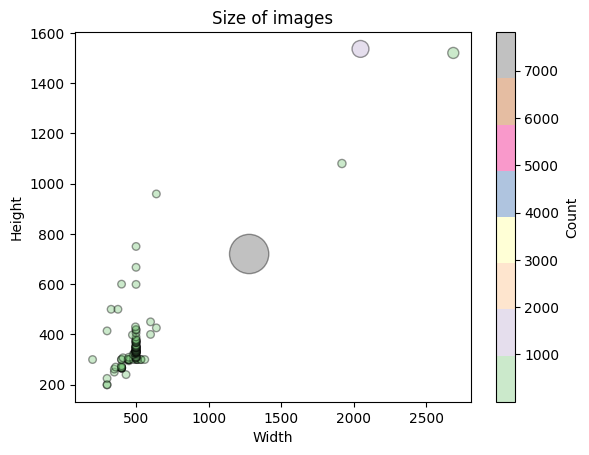

In [23]:
#TRAIN DATA
train_images_size_plot

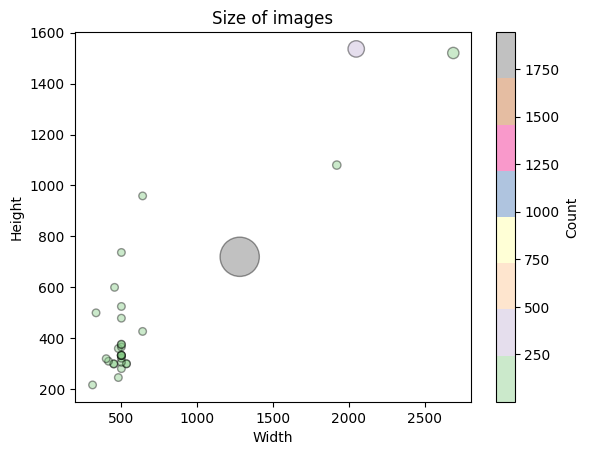

In [24]:
#VALID DATA
valid_images_size_plot

### Podsumowanie

W naszej analizie rozmiarów obrazów w zbiorze danych zdobyliśmy cenne informacje na temat rozkładu wymiarów obrazów - istotny aspekt przygotowań zbioru danych do szkolenia modelu detekcji obiektów. Możemy wyciągnąć następujące kluczowe obserwacje i wnioski:

1. **Różnorodność Rozmiarów Obrazów:** Nasz zbiór danych prezentuje szeroką różnorodność rozmiarów obrazów, o rozdzielczościach od najczęstszej wielkości 1280 x 720 do większych wymiarów, takich jak 2048 x 1536 i 2688 x 1520.

2. **Dominujące Rozmiary Obrazów:** Większość obrazów w zbiorze danych ma rozmiar 1280 x 720, stanowiący znaczną część zbioru. Dodatkowo, rozdzielczości takie jak 2048 x 1536 i 2688 x 1520 są również powszechne.

3. **Jakość Danych:** Pomimo oczekiwanej różnorodności rozmiarów obrazów, ważne jest ocenienie, czy istnieją jakiekolwiek nietypowe lub odstające rozmiary obrazów. Nasza analiza identyfikuje niewielką liczbę obrazów o rozmiarach takich jak 1920 x 1080 i 500 x 333, itp.

4. **Przygotowanie Danych:** Zrozumienie rozkładu rozmiarów obrazów jest kluczowe dla przetwarzania danych i konfiguracji modelu. W zależności od wybranej platformy detekcji obiektów może być konieczne przeskalowanie lub normalizacja obrazów, aby zapewnić jednolite rozmiary wejściowe podczas szkolenia.

Podsumowując, nasza analiza rozmiarów obrazów ujawnia różnorodność rozdzielczości w zbiorze danych, odzwierciedlając warunki rzeczywiste. To zrozumienie rozkładu rozmiarów obrazów jest kluczowe dla przetwarzania danych i optymalizacji konfiguracji modelu, aby zapewnić efektywne szkolenie w zakresie detekcji obiektów. Kolejne kroki mogą obejmować zmianę rozmiaru obrazów lub przyjęcie strategii radzenia sobie z różnicami w wymiarach obrazów.


# Analiza Liczby Adnotacji

## Wprowadzenie

W tej sekcji skupimy się na analizie liczby adnotacji w naszym zbiorze danych. Liczba adnotacji na każdym obrazie to istotny czynnik przy szkoleniu modelu detekcji obiektów. Zrozumienie rozkładu liczby adnotacji pozwala nam ocenić złożoność i bogactwo zbioru danych.

Poprzez analizę liczby adnotacji dążymy do zapewnienia, że nasz zbiór danych jest odpowiednio przygotowany do szkolenia modelu detekcji obiektów. Obejmuje to uwzględnienie rozkładu poziomów złożoności, potencjalnych odstępstw oraz wszelkich dostosowań potrzebnych do zoptymalizowania konfiguracji modelu.

Rozpocznijmy od przetwarzania danych w celu analizy rozkładu liczby adnotacji.


## Process

In [25]:
def annotation_count_summary(df, raw=False):
  df_copy = df.copy()
  df_copy = df_copy.groupby('image_id').agg(anno_count=('image_id', 'size'))
  df_copy = df_copy.value_counts().reset_index(name='image_count').set_index('anno_count')
  df_copy['percentage'] = ((df_copy['image_count']/df_copy['image_count'].sum())*100).round(2)
  if not raw:
    df_copy['percentage'] = df_copy['percentage'].astype(str) + ' %'
  return df_copy

In [26]:
def annotation_count_pie(df):
  VALUES_SPLIT = 5

  df_copy = df.copy()
  df_copy = annotation_count_summary(df_copy, raw=True).reset_index()
  last_values = df_copy.iloc[VALUES_SPLIT:][['image_count', 'percentage']].sum()
  last_df = pd.DataFrame([['6 and more',last_values['image_count'], last_values['percentage']]], columns=df_copy.columns)
  df_copy = pd.concat([df_copy.head(VALUES_SPLIT), last_df]).reset_index(drop=True)

  fig = plt.figure()
  wedges, texts, autotexts = plt.pie(df_copy['percentage'], autopct='%1.2f%%', textprops=dict(color="w"), pctdistance=0.8, startangle=45)
  plt.legend(wedges, df_copy['anno_count'],
            title="Annotation Count",
            loc="center",
            bbox_to_anchor=(1.05, 0, 0.5, 1))

  plt.setp(autotexts, size=8, weight="bold")

  plt.title("Percent of images with count")
  plt.close()
  return fig

In [27]:
def annotation_count_box(df):
  df_copy = df.copy()
  df_copy = df_copy.groupby('image_id').agg(anno_count=('image_id', 'size'))

  fig = plt.figure()
  bp = plt.boxplot(df_copy['anno_count'], patch_artist=True, vert=False, labels=[""])
  for median in bp['medians']:
    plt.setp(median, linewidth=2)

  for flier in bp['fliers']:
    plt.setp(flier, marker ='D',
              color ='#e7298a',
              alpha = 0.5)

  plt.title('No. of annotation in image')
  plt.xlabel('Count')

  plt.close()
  return fig

In [28]:
train_df = pd.DataFrame(train_info['annotations'], columns=['id','category_id', 'image_id'])
train_df.set_index('id', inplace=True)
valid_df = pd.DataFrame(valid_info['annotations'], columns=['id','category_id', 'image_id'])
valid_df.set_index('id', inplace=True)
train_df['category_name'] = train_df['category_id'].map(mapped_categories)
valid_df['category_name'] = valid_df['category_id'].map(mapped_categories)

In [29]:
train_annotation_count_summary = annotation_count_summary(train_df)
train_annotation_count_pie = annotation_count_pie(train_df)
train_annotation_count_box = annotation_count_box(train_df)
valid_annotation_count_summary = annotation_count_summary(valid_df)
valid_annotation_count_pie = annotation_count_pie(valid_df)
valid_annotation_count_box = annotation_count_box(valid_df)
del train_df, valid_df

## Show

### Podsumowanie Liczby Adnotacji

Wynikiem przetwarzania danych jest tabela, która dostarcza podsumowania liczby adnotacji w obrazie.


In [30]:
#TRAIN DATA
train_annotation_count_summary

,image_count,percentage
anno_count,,
1,4813,50.08 %
2,2211,23.0 %
3,1078,11.22 %
4,813,8.46 %
5,384,4.0 %
6,201,2.09 %
7,76,0.79 %
8,20,0.21 %
9,8,0.08 %


In [31]:
#VALID DATA
valid_annotation_count_summary

,image_count,percentage
anno_count,,
1,1200,50.7 %
2,517,21.84 %
3,258,10.9 %
4,206,8.7 %
5,93,3.93 %
6,68,2.87 %
7,20,0.84 %
8,3,0.13 %
10,2,0.08 %


### Wykres Kołowy Liczby Adnotacji

Wynikiem przetwarzania danych jest wykres kołowy, który wizualnie przedstawia rozkład liczby obrazów na podstawie liczby adnotacji w każdym obrazie. W tym wykresie każdy segment odpowiada określonej liczbie adnotacji, a wielkość każdego segmentu odzwierciedla procent obrazów, które mają dokładnie tę liczbę adnotacji. Ta wizualizacja zapewnia klarowny obraz tego, jak adnotacje są rozłożone na obrazach, podkreślając częstość występowania różnych liczb adnotacji.


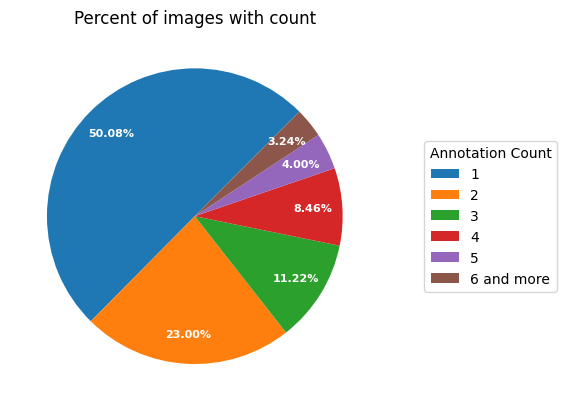

In [ ]:
#TRAIN DATA
train_annotation_count_pie

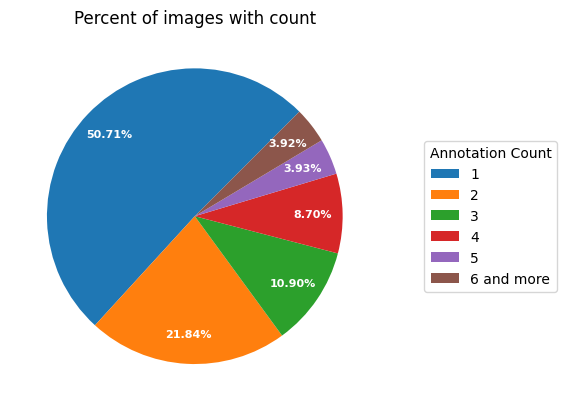

In [33]:
#VALID DATA
valid_annotation_count_pie

### Wykres Skrzynkowy Liczby Adnotacji

Ta funkcja generuje wykres skrzynkowy w celu wizualizacji rozkładu liczby adnotacji na obraz. Wykres skrzynkowy wyświetla statystyki takie jak mediana, kwartyle i potencjalne odstępstwa, dostarczając informacji na temat zmienności i rozkładu liczby adnotacji.


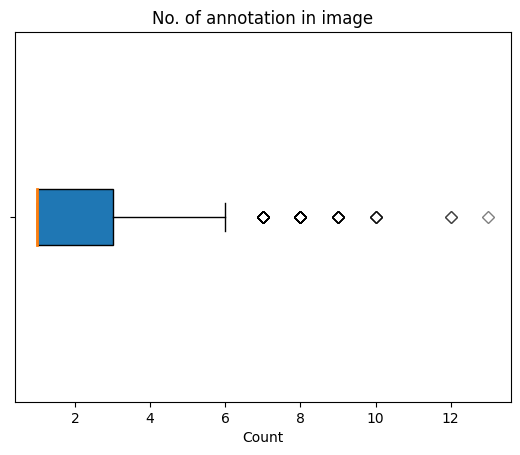

In [34]:
#TRAIN DATA
train_annotation_count_box

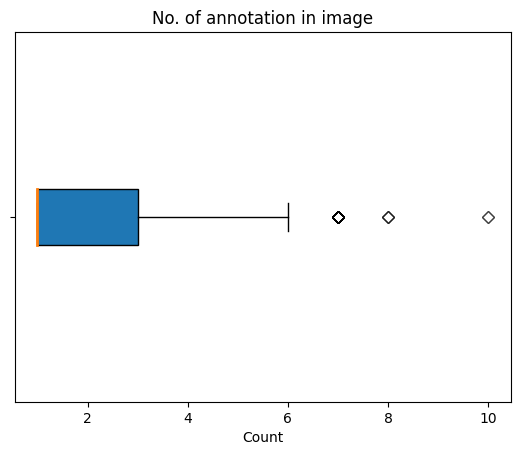

In [35]:
#VALID DATA
valid_annotation_count_box

### Podsumowanie

W naszej analizie liczby adnotacji w zbiorze danych zdobyliśmy cenne informacje na temat rozkładu adnotacji na obrazach - istotny aspekt przygotowań zbioru danych do szkolenia modelu detekcji obiektów. Możemy wyciągnąć następujące kluczowe obserwacje i wnioski:

1. **Dominacja Jednej Adnotacji:** Znacząca większość obrazów w zbiorze danych zawiera tylko jedną adnotację, stanowiąc ponad 50% zbioru danych. Oznacza to, że większość obrazów zawiera tylko jeden obiekt z adnotacją, co czyni je dominującą kategorią w zbiorze danych.

2. **Różnorodność Adnotacji:** Pomimo dominacji pojedynczych adnotacji, znaczna liczba obrazów zawiera wiele adnotacji. Obrazy z dwiema, trzema, czterema i pięcioma adnotacjami stanowią znaczną część zbioru danych, co pokazuje różnorodność obiektów w obrazach.

3. **Ograniczona Liczba Złożonych Adnotacji:** Obrazy z większą liczbą adnotacji, szczególnie sześcioma lub więcej, stanowią stosunkowo mały procent zbioru danych. Te przypadki są mniej liczne i mogą być uważane za bardziej złożone, zwykle obejmują wiele obiektów zainteresowania na jednym obrazie.

Podsumowując, nasza analiza liczby adnotacji podkreśla dominację obrazów z pojedynczymi adnotacjami, które stanowią większość zbioru danych. To zrozumienie rozkładu liczby adnotacji jest istotne dla przetwarzania danych i optymalizacji konfiguracji modelu, aby zapewnić efektywne szkolenie w zakresie detekcji obiektów.


# Rozmiar i Umiejscowienie Adnotacji

W tej sekcji naszej analizy zagłębimy się w charakterystykę adnotacji w zbiorze danych. Konkretnie, będziemy badać rozmiar i umiejscowienie adnotacji na obiektach. Zrozumienie wymiarów i rozkładu przestrzennego adnotacji jest istotne dla dostrojenia modeli detekcji obiektów. Ta analiza pozwala nam uzyskać wgląd w to, jak obiekty są adnotowane w zbiorze danych, dostarczając cennych informacji dla treningu i oceny modelu.

W miarę postępowania będziemy badać kluczowe aspekty związane z rozmiarem i umiejscowieniem adnotacji, analizować odpowiednie metryki oraz wizualizować obserwowane wzorce w zbiorze danych.


## Process


In [36]:
def annotation_data_catogorized(df, column):
  df_copy = df.copy()

  categories = []
  cat_data = []
  for cat, data in df_copy.groupby('category_name'):
    categories.append(cat)
    cat_data.append(data[column].values)
  return categories, cat_data

In [37]:
def annotation_area_summary(df):
   df_copy = df.copy()
   df_agg = df_copy.groupby('category_name').agg(median=('area', 'median'), avarege=('area', 'mean'), count=('area', 'size')).astype(int)
   return df_agg

In [83]:
def annotation_area_box(df):
  df_copy = df.copy()
  categories, cat_data = annotation_data_catogorized(df_copy, 'area')

  fig, axes = plt.subplots(3, 4, figsize=(12,6))
  axes = axes.ravel()
  for i, (category, data) in enumerate(zip(categories, cat_data)):
    ax = axes[i]
    ax.boxplot(data, labels=[''], patch_artist=True, vert=False)
    ax.set_title(category)
    ax.ticklabel_format(axis='x', style='scientific', scilimits=(0,5))

  fig.suptitle('Box plots of area covered', fontsize=14, y=0.97)
  plt.tight_layout()
  plt.close()
  return fig

In [84]:
def annotation_area_hist(df):
  df_copy = df.copy()
  categories, cat_data = annotation_data_catogorized(df_copy, 'area')

  fig, axes = plt.subplots(3, 4, figsize=(12,6))
  axes = axes.ravel()
  for i, (category, data) in enumerate(zip(categories, cat_data)):
    ax = axes[i]
    ax.hist(data, bins=20, edgecolor='white')
    ax.axvline(np.median(data), c='r', linestyle='--', linewidth=1)
    ax.set_title(category)
    ax.set_xlabel('area')
    ax.ticklabel_format(axis='x', style='sci', scilimits=(0,5))

  fig.text(0.05, 0.95, 'red Line - median', ha='left', fontsize=10)
  fig.suptitle('Frequency of area covered', fontsize=14, y=0.97)
  plt.tight_layout()
  plt.close()
  return fig

In [76]:
def annotation_position_plot(df):
  df_copy = df.copy()
  categories, cat_data = annotation_data_catogorized(df, 'bbox')
  fig, axes = plt.subplots(3, 4, figsize=(14,8))
  axes = axes.ravel()
  for i, (category, data) in enumerate(zip(categories, cat_data)):
    ax = axes[i]
    ax.scatter([x[0] for x in data], [x[1] for x in data], s=30, alpha=0, edgecolor='w', linewidth=0.5)
    ax.set_ylim(bottom=0)
    ax.set_xlim(left=0)
    if max(data, key=lambda x: x[0])[0] < 1282:
      ax.set_xlim(right=1282)
    if max(data, key=lambda x: x[1])[1] < 723:
      ax.set_ylim(top=723)

    ax.invert_yaxis()
    ax.set_title(category)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    rect = Rectangle((2,2), 1278, 718, edgecolor='r',fill=False, linewidth=1)
    ax.add_patch(rect)
    for x, y, width, height in data:
      rect = Rectangle((x,y), width, height, alpha=0.3, fill=False, lw=0.5, edgecolor='b')
      ax.add_patch(rect)

  fig.text(0.05, 0.95, 'red Box - size 1280 x 720', ha='left', fontsize=10)
  fig.suptitle('Annotation placement', fontsize=14, y=0.97)
  plt.tight_layout()
  plt.close()
  return fig

In [85]:
train_df = pd.DataFrame(train_info['annotations'], columns=['id', 'image_id', 'category_id', 'bbox', 'area'])
valid_df = pd.DataFrame(valid_info['annotations'], columns=['id', 'image_id', 'category_id', 'bbox', 'area'])
train_df.set_index('id', inplace=True)
valid_df.set_index('id', inplace=True)
train_df['category_name'] = train_df['category_id'].map(mapped_categories)
valid_df['category_name'] = valid_df['category_id'].map(mapped_categories)

In [86]:
train_annotation_area_summary = annotation_area_summary(train_df)
train_annotation_area_box = annotation_area_box(train_df)
train_annotation_area_hist = annotation_area_hist(train_df)
# train_annotation_position_plot = annotation_position_plot(train_df)
valid_annotation_area_summary = annotation_area_summary(valid_df)
valid_annotation_area_box = annotation_area_box(valid_df)
valid_annotation_area_hist = annotation_area_hist(valid_df)
# valid_annotation_position_plot = annotation_position_plot(valid_df)
del train_df, valid_df

## Show

### Podsumowanie Obszaru Adnotacji

Ta sekcja dostarcza podsumowania adnotowanych obiektów w zbiorze danych, podzielonych według typu obiektu. Obejmuje medianę i średnią wartość obszaru dla każdej kategorii, oferując informacje na temat rozmiarów obiektów, wraz z całkowitą liczbą adnotacji.


In [48]:
#TRAIN DATA
train_annotation_area_summary

,median,avarege,count
category_name,,,
Glove,12264,12910,3705
Goggles,3034,4460,3361
Helmet,6544,5879,1240
Mask,5775,6721,211
No glove,8901,10452,4885
No goggles,2805,4554,3293
No helmet,7070,7029,1067
No mask,3850,10905,524
No shoes,2800,3529,463


In [49]:
#VALID DATA
valid_annotation_area_summary

,median,avarege,count
category_name,,,
Glove,12141,12489,958
Goggles,3003,4530,823
Helmet,7650,7383,283
Mask,5892,6669,58
No glove,8835,10552,1241
No goggles,2775,4715,799
No helmet,7656,8146,229
No mask,3850,12451,137
No shoes,2800,4627,143


### Wykres Skrzynkowy Obszaru Adnotacji

Ta sekcja prezentuje serię wykresów skrzynkowych, z których każdy odpowiada odrębnej kategorii obiektu. Wykresy skrzynkowe wizualnie przedstawiają rozkład obszarów adnotowanych obiektów w każdej kategorii. Te wykresy zapewniają klarowny przegląd rozprzestrzenienia i zmienności rozmiarów obiektów, co pomaga w analizie cech zbioru danych.


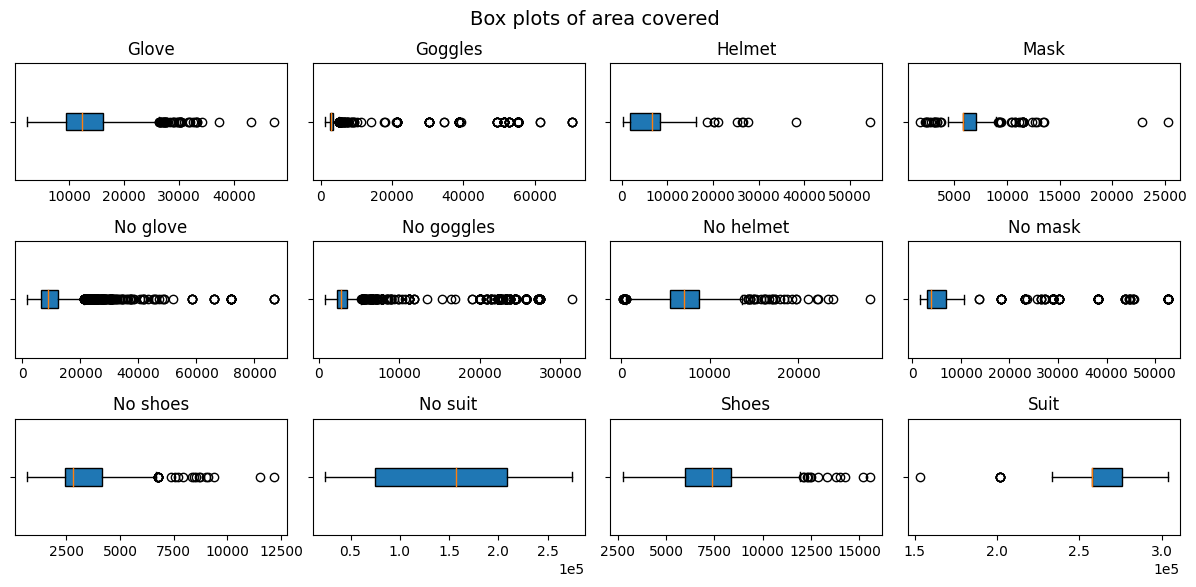

In [87]:
#TRAIN DATA
train_annotation_area_box

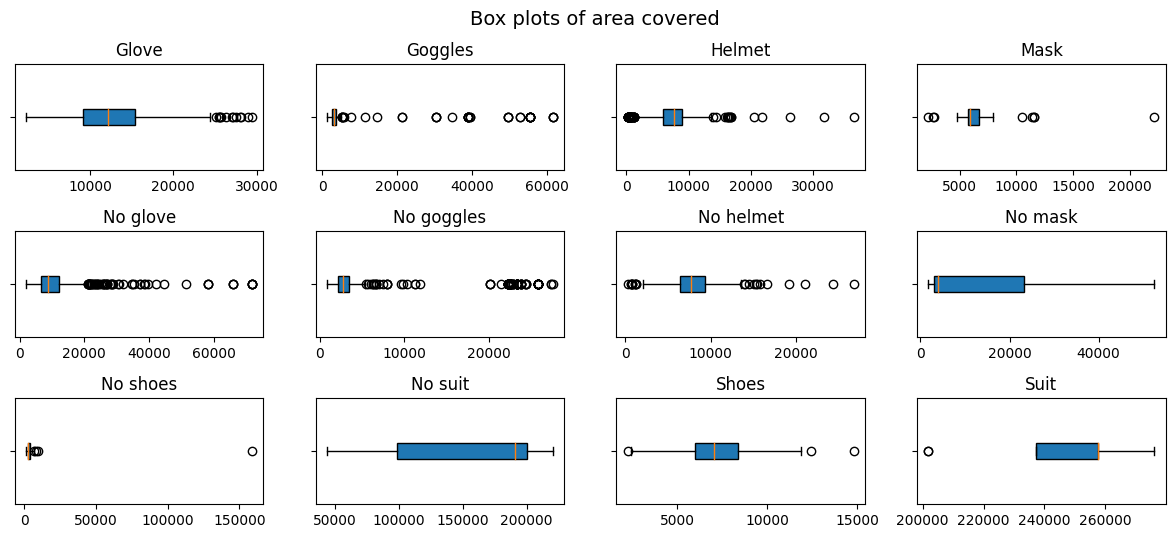

In [58]:
#VALID DATA
valid_annotation_area_box

### Histogram Obszaru Adnotacji

W tej sekcji przedstawiamy histogramy przedstawiające rozkład obszarów adnotowanych obiektów dla różnych kategorii obiektów. Każdy histogram oferuje informacje na temat częstotliwości różnych zakresów obszarów, pozwalając nam zobaczyć, jak rozmiary obiektów są rozkładane w każdej kategorii. Czerwona przerywana linia w każdym histogramie reprezentuje medianę wartości obszaru, dostarczając centralnego punktu odniesienia do analizy.


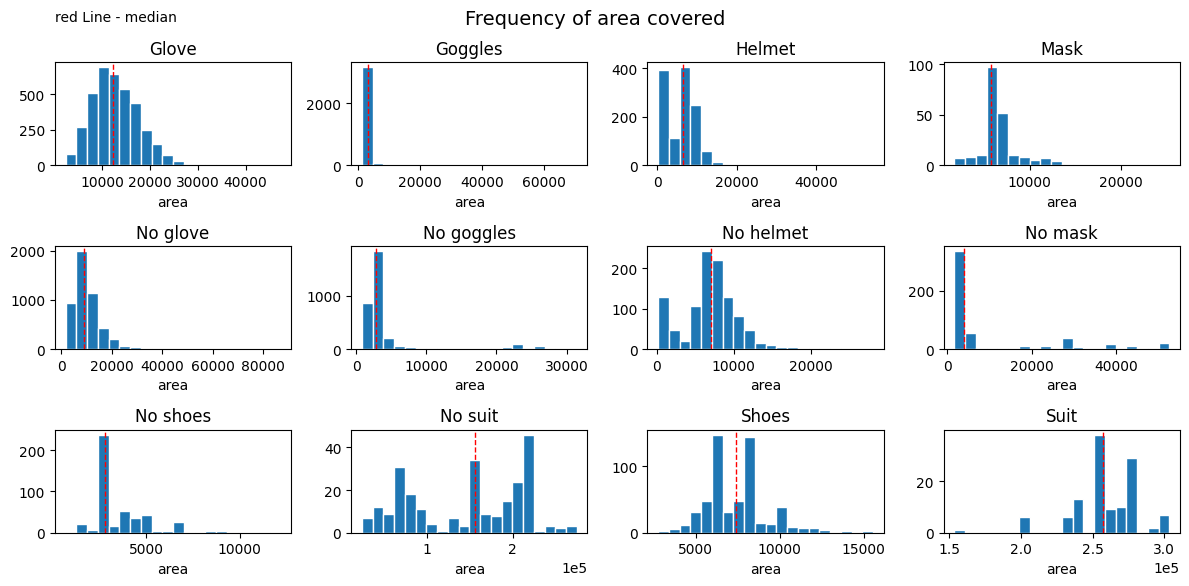

In [88]:
#TRAIN DATA
train_annotation_area_hist

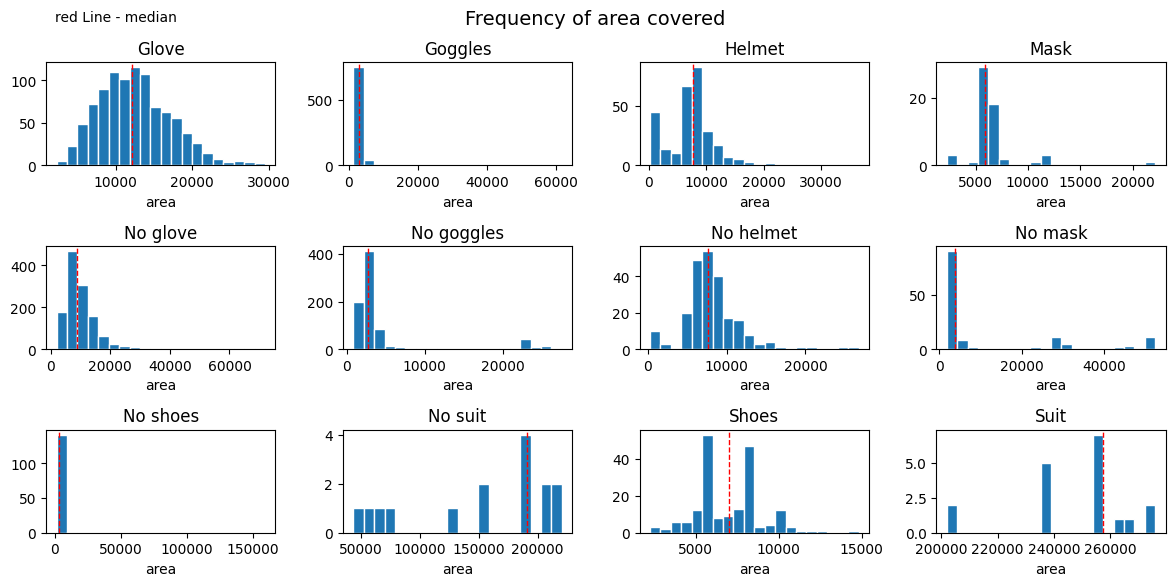

In [53]:
#VALID DATA
valid_annotation_area_hist

### Pozycja Ramki Adnotacji

W tej sekcji analizujemy umiejscowienie ramek adnotacji dla różnych kategorii obiektów. Każdy subplot przedstawia wykres rozrzutu reprezentujący położenie ramek adnotacji w ramach danej kategorii. Współrzędne x i y wskazują położenie adnotacji, a niebieskie prostokąty otaczają ramki adnotacji. Czerwony nie wypełniony prostokąt reprezentuje standardowy rozmiar 1280 x 720, dostarczając ramy odniesienia. Ta analiza pomaga zrozumieć, jak obiekty są umiejscowione na obrazach i dostarcza informacji na temat ich przestrzennego rozkładu.


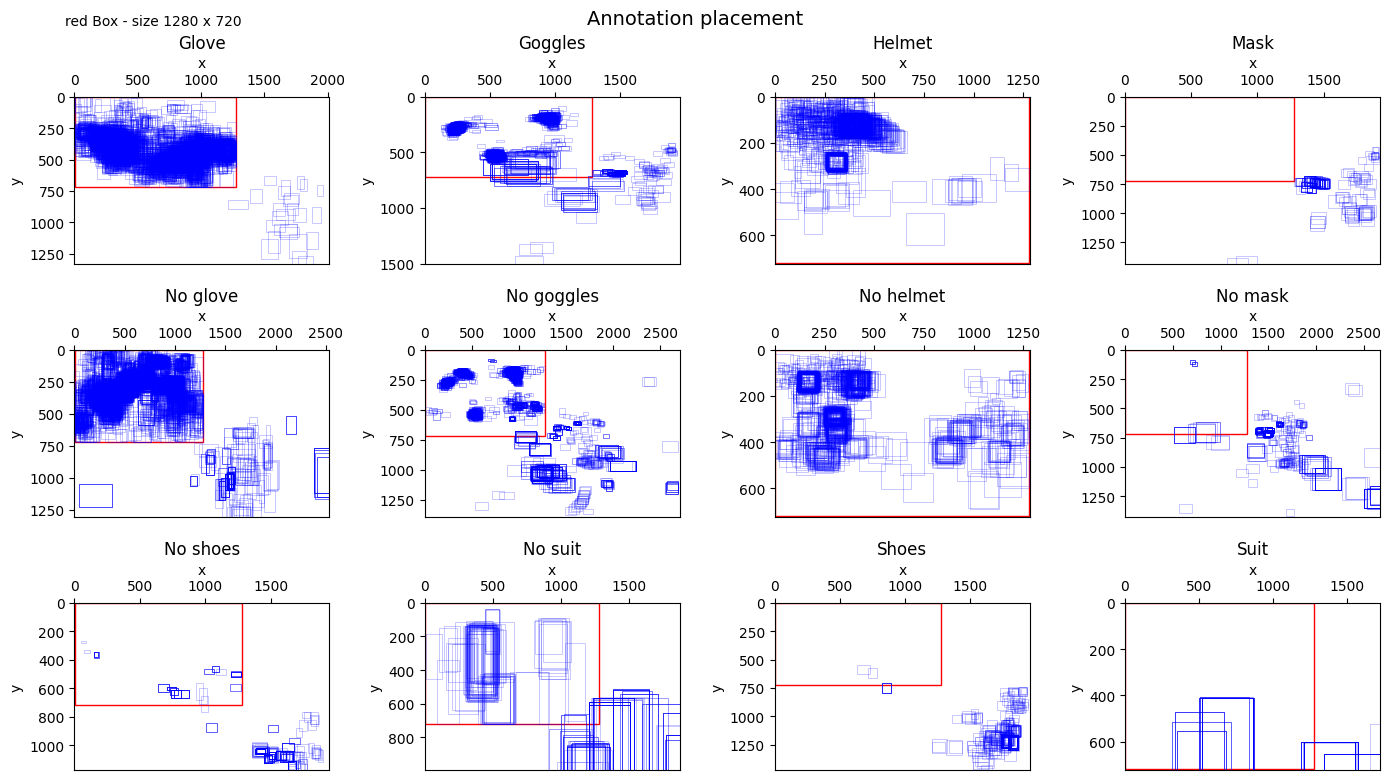

In [46]:
#TRAIN DATA
train_annotation_position_plot

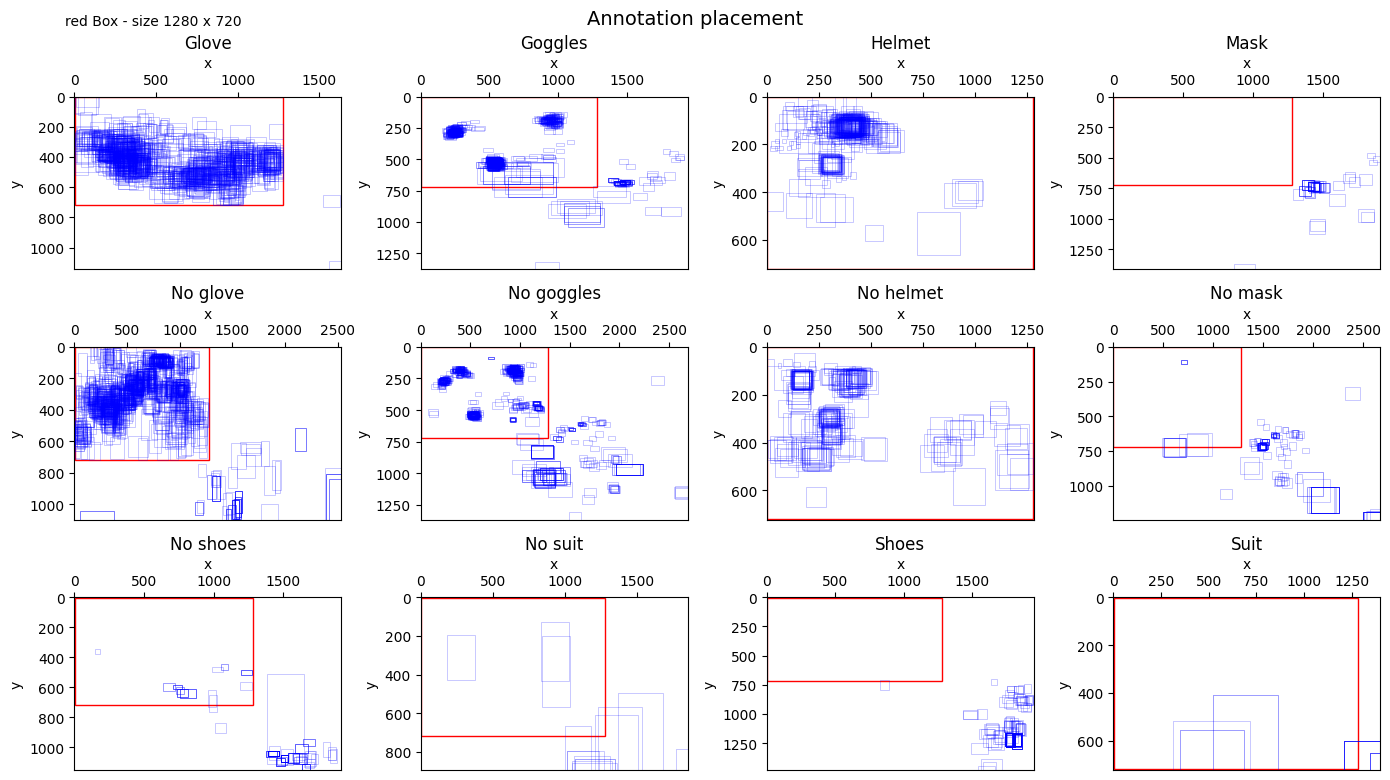

In [47]:
#VALID DATA
valid_annotation_position_plot

### Podsumowanie

W naszej analizie danych adnotacji odkryliśmy cenne informacje na temat umiejscowienia i rozmiaru adnotacji w różnych kategoriach obiektów w zbiorze danych. Możemy wyciągnąć następujące kluczowe obserwacje i wnioski:

1. **Jednolity Obszar Adnotacji:** W przypadku większości kategorii obiektów adnotacje mają tendencję do pokrywania podobnych obszarów. Ta jednolitość sugeruje, że dla wielu klas obiekty są adnotowane w stosunkowo jednolitym zakresie rozmiarów. Ta jednolitość obszaru adnotacji może być korzystna dla treningu i oceny modelu, ponieważ wskazuje na standaryzowaną reprezentację obiektów.

2. **Większe Rozmiary dla Określonych Kategorii:** Warto zauważyć, że kategorie obiektów związane z "butami" i "maską" wykazują większe rozmiary adnotacji w porównaniu do najczęstszej rozdzielczości obrazu wynoszącej 1280 x 720 pikseli. To odchylenie w rozmiarze sugeruje, że obiekty w tych kategoriach są często większe lub zajmują znaczną część obrazu.

Podsumowując, nasza analiza umiejscowienia i rozmiaru adnotacji dostarcza istotnego kontekstu dla przygotowań zbioru danych i treningu modelu. Podkreśla zarówno jednolitość, jak i odstępstwa w obszarze adnotacji między kategoriami obiektów, ze szczególnym uwzględnieniem większych rozmiarów w wybranych kategoriach. Te spostrzeżenia przyczyniają się do optymalizacji modeli detekcji obiektów i ich zdolności do dokładnego identyfikowania i klasyfikowania obiektów o różnych rozmiarach w zbiorze danych.


# Podsumowanie Końcowe

## Opis Zadania
Dział R&amp;D potrzebuje przygotować eksperymentalny trening modelu wykrywającego obiekty, więc
skontaktował się z Tobą w celu sprawdzenia, czy przygotowany przez zespół tworzący adnotacje zdjęć,
zbiór jest wystarczający, aby uruchomić trening.

## Odpowiedź
Po zanalizowaniu zbioru danych wyraźnie widać, że istnieje nierównowaga w rozkładzie klas obiektów. Niektóre klasy są silnie reprezentowane, podczas gdy inne mają znacznie mniejszą liczbę instancji. Aby rozwiązać ten problem i poprawić proces treningu, zalecałbym rozważenie technik augmentacji danych lub wprowadzenie wag klas podczas treningu. Pomoże to zapewnić, że model efektywnie uczy się ze wszystkich klas, co przyczyni się do lepszej wydajności detekcji obiektów we wszystkich kategoriach obiektów.
